In [1]:
!pip install yfinance
!pip install altair
!pip install streamlit
!pip install itertools
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\kanno.ryuho\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\kanno.ryuho\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\kanno.ryuho\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\kanno.ryuho\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\kanno.ryuho\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import altair as alt
import yfinance as yf
import streamlit as st
import itertools
import statsmodels.api as sm

%matplotlib inline

In [2]:
days = 365
tickers = {
    'Apple': 'AAPL',
    'Google': 'GOOG',
    'Microsoft': 'MSFT',
    'Netflix': 'NFLX',
    'Amazon': 'AMZN',
    'Meta': 'META',
    'Rakuten': '4755.T',
    'TOYOTA': '7203.T',
    'SONY': '6758.T'
}

c:\Users\kanno.ryuho\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\kanno.ryuho\AppData\Local\Temp\ipykernel_19856\3394126845.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(rule = "M").mean()


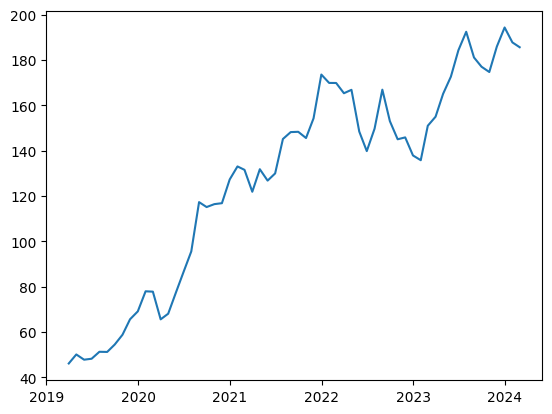

In [3]:
## 終値を抽出処理
## downloadメソッド使用ver

ticker = 'AAPL'
df = pd.DataFrame()

def get_close_for_predict_with_download(ticker):
    df = pd.DataFrame()

    current_date = datetime.now()

    five_years_ago = current_date - timedelta(days=365 * 5)
    five_years_ago_str = five_years_ago.strftime("%Y-%m-%d")

    one_week_ago = current_date - timedelta(days=7)
    one_week_ago_str = one_week_ago.strftime("%Y-%m-%d")

    two_years_later = current_date + timedelta(days=365 * 2)

    # df = yf.download(ticker, start="2018-01-01", end="2024-2-20", interval="1d")
    df = yf.download(ticker, start=five_years_ago_str, end=one_week_ago_str, interval="1d")

    #1ヶ月毎のデータに変更しシンプルにする
    df = df.resample(rule = "M").mean()

    plt.plot(df["Close"])
    plt.show()

    return df["Close"]

df["Close"] = get_close_for_predict_with_download(ticker)

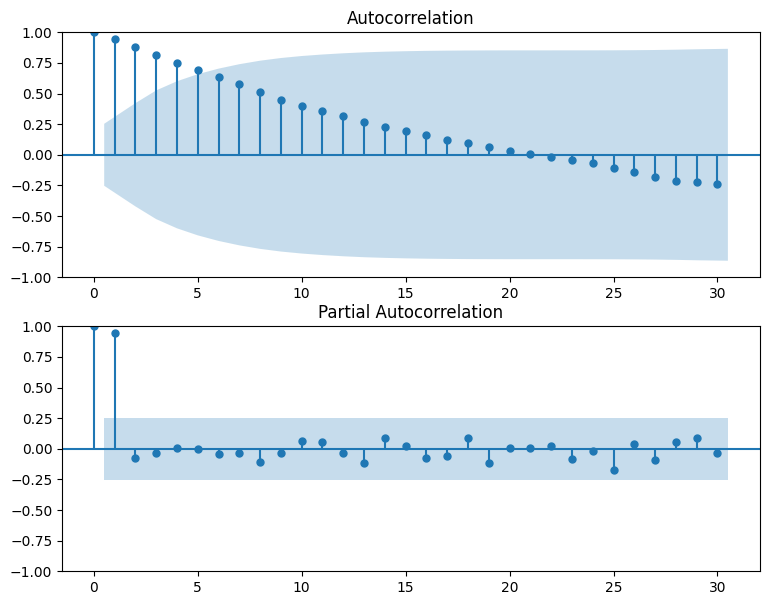

In [4]:
## 自己相関・偏自己相関の可視化
fig = plt.figure(figsize=(9,7))

## 自己相関係数をグラフ化
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["Close"], lags=30, ax=ax1)

## 偏自己相関係数をグラフ化
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["Close"], lags=30, ax=ax2)

plt.show()

In [ ]:
## 季節調整
sm.tsa.seasonal_decompose(df["Close"], period=12).plot()
plt.show()

In [ ]:
## モデル構築のためのパラメータの決定

def selectparameter(DATA,s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    BICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA,
                                                order=param,
                                                seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.bic])
                BICs = np.append(BICs, results.bic)
            except:
                continue
    return parameters[np.argmin(BICs)]

selectparameter(df["Close"],12)


In [10]:
#モデルの構築
SARIMA_MSFT = sm.tsa.statespace.SARIMAX(df["Close"],order=(0, 1, 0),seasonal_order=(0, 1, 1, 12)).fit()

print(SARIMA_MSFT.bic)


353.8929343955401


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [ ]:
#predに予測データを代入
pred = SARIMA_MSFT.predict('2021-01', '2025-12')

print(pred)

#predと元の時系列データを可視化
#予測データは赤色で表示
plt.plot(df["Close"])
plt.plot(pred, "r")
plt.show()


In [27]:
ticker = tickers['Apple']

def get_predict(ticker):
    df = pd.DataFrame()

    current_date = datetime.now()

    five_years_ago = current_date - timedelta(days=365 * 5)
    five_years_ago_str = five_years_ago.strftime("%Y-%m-%d")

    one_week_ago = current_date - timedelta(days=7)
    one_week_ago_str = one_week_ago.strftime("%Y-%m-%d")

    two_years_later = current_date + timedelta(days=365 * 2)

    df = yf.download(ticker, start=five_years_ago_str, end=one_week_ago_str, interval="1d")

    #1ヶ月毎のデータに変更しシンプルにする
    df = df.resample(rule = "M").mean()

    # モデルの構築
    SARIMA_MSFT = sm.tsa.statespace.SARIMAX(df["Close"],order=(0, 1, 0),seasonal_order=(0, 1, 1, 12)).fit()

    # predに予測データを代入
    pred = SARIMA_MSFT.predict(five_years_ago.strftime("%Y-%m"), two_years_later.strftime("%Y-%m"))

    return pred, df["Close"]

data_predict, data_close = get_predict('AAPL')

data_predict = data_predict.T.reset_index()
data_close = data_close.T.reset_index()

data_predict = data_predict.rename({'predicted_mean': 'prediction_line'}, axis=1)
data_predict = data_predict.rename({'index': 'Date'}, axis=1)

data_predict = pd.melt(data_predict, id_vars=['Date']).rename(
  columns={'value': 'Stock Prices(USD)', 'variable': 'Name'}
)

data_close = pd.melt(data_close, id_vars=['Date']).rename(
  columns={'value': 'Stock Prices(USD)', 'variable': 'Name'}
)

data_predict["Date"] = pd.to_datetime(data_predict['Date'])
data_predict["Date"] = data_predict["Date"].dt.strftime('%d %B %Y')

data_predict, data_close
# # plt.plot(df["Close"])
# # plt.plot(data_predict, "r")
# # plt.show()


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(                Date             Name  Stock Prices(USD)
 0      31 March 2019  prediction_line           0.000000
 1      30 April 2019  prediction_line          46.150278
 2        31 May 2019  prediction_line          50.129048
 3       30 June 2019  prediction_line          47.818409
 4       31 July 2019  prediction_line          48.242250
 ..               ...              ...                ...
 80  30 November 2025  prediction_line         229.675464
 81  31 December 2025  prediction_line         236.420372
 82   31 January 2026  prediction_line         236.864466
 83  28 February 2026  prediction_line         239.137224
 84     31 March 2026  prediction_line         233.540647
 
 [85 rows x 3 columns],
          Date   Name  Stock Prices(USD)
 0  2019-03-31  Close          46.150278
 1  2019-04-30  Close          50.129048
 2  2019-05-31  Close          47.818409
 3  2019-06-30  Close          48.242250
 4  2019-07-31  Close          51.304091
 5  2019-08-31  Close          5